### **PCA Analysis**

Dataset loaded with shape: (8763, 26)
Number of components needed for 80% variance: 19

Top 5 features for PC1:
  - Smoking: 0.5259
  - Sex: 0.4248
  - Country: 0.4199
  - Continent: 0.3988
  - Age: 0.3233

Top 5 features for PC2:
  - Country: 0.4702
  - Smoking: 0.4631
  - Continent: 0.4450
  - Hemisphere: 0.3779
  - Sex: 0.3656

Top 5 features for PC3:
  - Cholesterol: 0.4528
  - Stress Level: 0.4169
  - Sleep Hours Per Day: 0.3393
  - Triglycerides: 0.2635
  - Exercise Hours Per Week: 0.2576
PCA analysis completed!


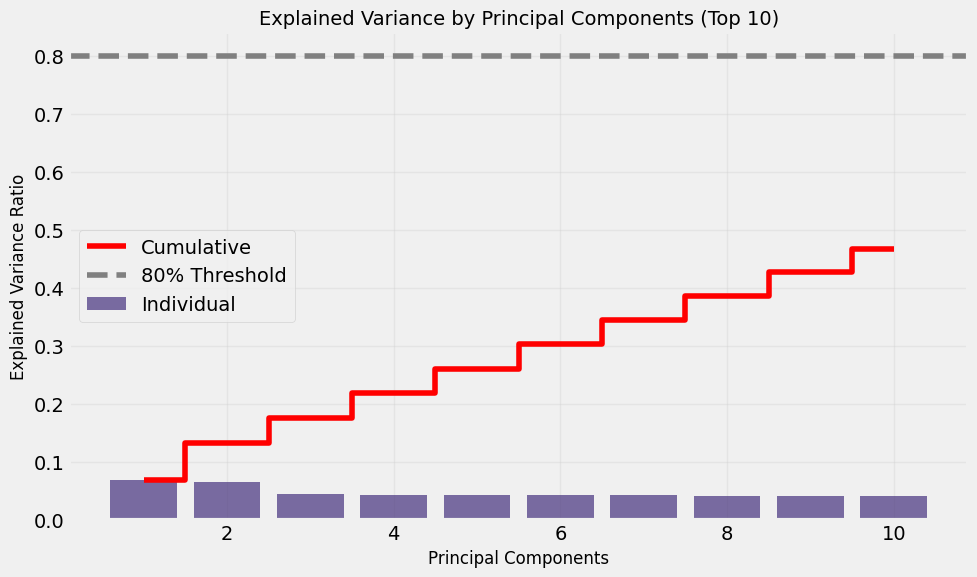

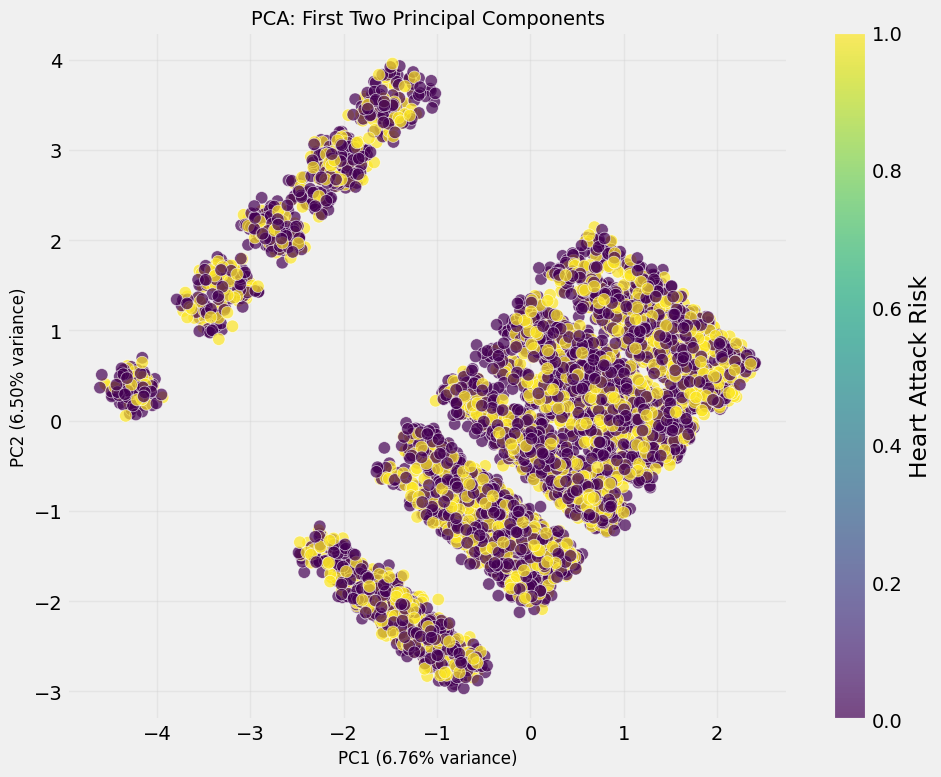

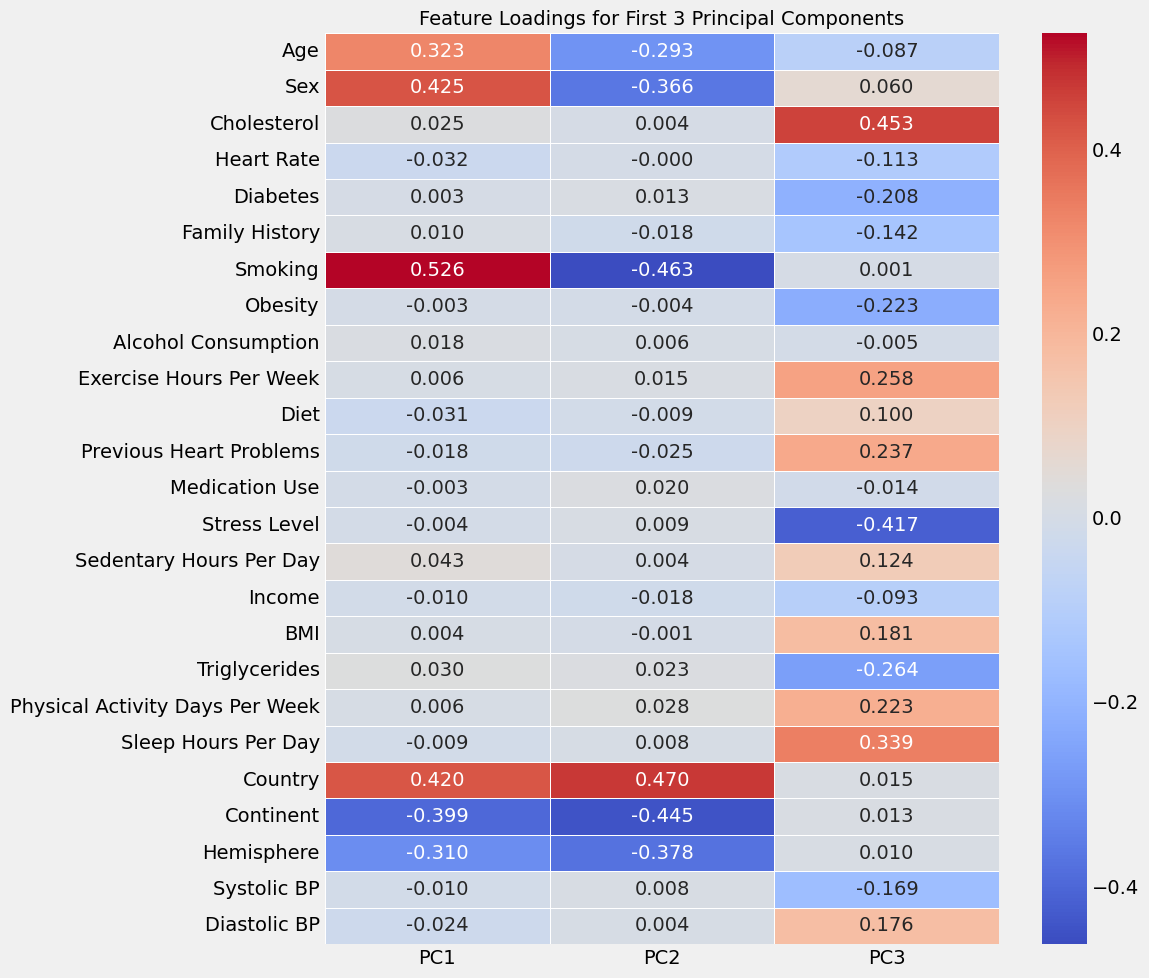

In [8]:
# What this PCA creates
# The first chart shows which components contain the most information, helping us determine what model would be the best fit for training
# The scatter plot reveals how patients naturally group together, showing if our data can be clearly separated by heart attack risk
# The analysis tells us exactly how many features we actually need, so we can simplify our model without losing important information
# The heatmap highlights which original measurements (like blood pressure or cholesterol) are most influential, guiding our feature selection
# Overall, this PCA gives us a roadmap for building a more efficient heart attack prediction model by focusing on what really matters


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

df = pd.read_csv('/content/heart_attack_prediction_dataset.csv')
print(f"Dataset loaded with shape: {df.shape}")

df['Systolic BP'] = df['Blood Pressure'].apply(lambda x: int(x.split('/')[0]))
df['Diastolic BP'] = df['Blood Pressure'].apply(lambda x: int(x.split('/')[1]))

categorical_features = df.select_dtypes(include=['object']).columns.tolist()
df_pca = df.copy()

for feature in categorical_features:
    le = LabelEncoder()
    df_pca[feature] = le.fit_transform(df[feature])

exclude_cols = ['Patient ID', 'Heart Attack Risk', 'Blood Pressure']
all_features = [col for col in df_pca.columns if col not in exclude_cols]

X = df_pca[all_features].values
y = df_pca['Heart Attack Risk'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), explained_variance[:10], alpha=0.7, label='Individual')
plt.step(range(1, 11), cumulative_variance[:10], where='mid', color='red', label='Cumulative')
plt.axhline(y=0.8, color='gray', linestyle='--', label='80% Threshold')
plt.title('Explained Variance by Principal Components (Top 10)', fontsize=14)
plt.xlabel('Principal Components', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('pca_variance.png', dpi=300)

n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
print(f"Number of components needed for 80% variance: {n_components_80}")

pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Heart Attack Risk': y
})

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_df['PC1'], pca_df['PC2'],
    c=pca_df['Heart Attack Risk'],
    cmap='viridis',
    s=80, alpha=0.7,
    edgecolors='w', linewidth=0.5
)
plt.colorbar(scatter, label='Heart Attack Risk')
plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variance)', fontsize=12)
plt.title('PCA: First Two Principal Components', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('pca_2d.png', dpi=300)

loadings = pd.DataFrame(
    pca.components_.T[:, :3],
    columns=['PC1', 'PC2', 'PC3'],
    index=all_features
)

for i in range(3):
    pc = f'PC{i+1}'
    print(f"\nTop 5 features for {pc}:")
    abs_loadings = loadings[pc].abs().sort_values(ascending=False).head(5)
    for feature, loading in abs_loadings.items():
        print(f"  - {feature}: {loading:.4f}")

plt.figure(figsize=(12, 10))
sns.heatmap(loadings, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5)
plt.title('Feature Loadings for First 3 Principal Components', fontsize=14)
plt.tight_layout()
plt.savefig('pca_loadings.png', dpi=300)

print("PCA analysis completed!")

### **Preprocessing**




In [9]:
# Prioritized features identified as significant in PCA: Smoking, Sex, Country, Cholesterol, Stress Level, and Sleep Hours
# Created targeted categorical features and weighted risk scores based on PCA contributions, with Smoking receiving double weight due to its dominance in PC1
# Applied standard scaling to numerical features, one-hot encoding to categorical variables,
# and selected exactly 19 features to match the PCA finding that 19 components explain 80% variance
# Emphasized geographic features through combination variables since Country, Continent, and Hemisphere were important in both PC1 and PC2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

print("Starting optimized data preprocessing pipeline...")

df = pd.read_csv('/content/heart_attack_prediction_dataset.csv')
print(f"Dataset loaded with shape: {df.shape}")

print("\nFirst 5 rows:")
print(df.head())

print("\nChecking data types and missing values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print("Missing values found:")
    print(missing[missing > 0])
else:
    print("No missing values found")

print("\nPerforming feature engineering with focus on PCA insights...")

df['Systolic BP'] = df['Blood Pressure'].apply(lambda x: int(x.split('/')[0]))
df['Diastolic BP'] = df['Blood Pressure'].apply(lambda x: int(x.split('/')[1]))

df['Pulse Pressure'] = df['Systolic BP'] - df['Diastolic BP']

bmi_bins = [0, 18.5, 25, 30, 35, 100]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Severely Obese']
df['BMI Category'] = pd.cut(df['BMI'], bins=bmi_bins, labels=bmi_labels)

age_bins = [0, 30, 40, 50, 60, 70, 80, 100]
age_labels = ['<30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']
df['Age Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)

chol_bins = [0, 200, 240, 1000]
chol_labels = ['Desirable', 'Borderline High', 'High']
df['Cholesterol Category'] = pd.cut(df['Cholesterol'], bins=chol_bins, labels=chol_labels)

trig_bins = [0, 150, 200, 500, 1000]
trig_labels = ['Normal', 'Borderline High', 'High', 'Very High']
df['Triglycerides Category'] = pd.cut(df['Triglycerides'], bins=trig_bins, labels=trig_labels)

def bp_category(sys, dia):
    if sys < 120 and dia < 80:
        return 'Normal'
    elif (120 <= sys <= 129) and dia < 80:
        return 'Elevated'
    elif (130 <= sys <= 139) or (80 <= dia <= 89):
        return 'Stage 1 Hypertension'
    elif sys >= 140 or dia >= 90:
        return 'Stage 2 Hypertension'
    else:
        return 'Unknown'

df['BP Category'] = df.apply(lambda x: bp_category(x['Systolic BP'], x['Diastolic BP']), axis=1)

stress_bins = [0, 3, 7, 10]
stress_labels = ['Low', 'Medium', 'High']
df['Stress Category'] = pd.cut(df['Stress Level'], bins=stress_bins, labels=stress_labels)

sleep_bins = [0, 6, 8, 24]
sleep_labels = ['Insufficient', 'Optimal', 'Excessive']
df['Sleep Category'] = pd.cut(df['Sleep Hours Per Day'], bins=sleep_bins, labels=sleep_labels)

exercise_bins = [0, 1, 3, 24]
exercise_labels = ['Sedentary', 'Moderate', 'Active']
df['Exercise Category'] = pd.cut(df['Exercise Hours Per Week'], bins=exercise_bins, labels=exercise_labels)

medical_risk_factors = ['Diabetes', 'Family History', 'Previous Heart Problems']
df['Medical Risk Score'] = df[medical_risk_factors].sum(axis=1)

lifestyle_risk_factors = ['Obesity', 'Alcohol Consumption']
df['Lifestyle Risk Score'] = df[lifestyle_risk_factors].sum(axis=1) + (df['Smoking'] * 2)

df['Geo_Region'] = df['Continent'] + "_" + df['Hemisphere']

print("Created new features, with emphasis on PCA-significant variables")

print("\nDefining feature types for preprocessing...")

id_column = ['Patient ID']

target_column = ['Heart Attack Risk']

drop_features = ['Blood Pressure']

high_priority_numerical = [
    'Age', 'Cholesterol', 'Triglycerides', 'Stress Level',
    'Sleep Hours Per Day', 'Exercise Hours Per Week'
]

medium_priority_numerical = [
    'Heart Rate', 'Systolic BP', 'Diastolic BP', 'Pulse Pressure',
    'Sedentary Hours Per Day', 'BMI', 'Physical Activity Days Per Week',
    'Medical Risk Score', 'Lifestyle Risk Score'
]

numerical_features = high_priority_numerical + medium_priority_numerical

high_priority_binary = ['Smoking']
medium_priority_binary = [
    'Diabetes', 'Family History', 'Obesity',
    'Alcohol Consumption', 'Previous Heart Problems', 'Medication Use'
]
binary_features = high_priority_binary + medium_priority_binary

high_priority_categorical = ['Sex', 'Country', 'Continent', 'Hemisphere', 'Geo_Region']
medium_priority_categorical = [
    'Diet', 'BMI Category', 'Age Group', 'Cholesterol Category',
    'Triglycerides Category', 'BP Category', 'Stress Category',
    'Sleep Category', 'Exercise Category'
]
categorical_features = high_priority_categorical + medium_priority_categorical

print("\nSplitting data into training and testing sets...")
X = df.drop(id_column + target_column + drop_features, axis=1)
y = df[target_column].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

print("\nCreating preprocessing pipelines...")

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num_high', numerical_transformer, high_priority_numerical),
        ('num_med', numerical_transformer, medium_priority_numerical),
        ('bin_high', binary_transformer, high_priority_binary),
        ('bin_med', binary_transformer, medium_priority_binary),
        ('cat_high', categorical_transformer, high_priority_categorical),
        ('cat_med', categorical_transformer, medium_priority_categorical)
    ]
)

print("\nFitting preprocessing pipeline on training data...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed testing data shape: {X_test_processed.shape}")

print("\nPerforming feature selection guided by PCA insights...")

n_components_from_pca = 19
selector = SelectKBest(f_classif, k=n_components_from_pca)
X_train_selected = selector.fit_transform(X_train_processed, y_train)
X_test_selected = selector.transform(X_test_processed)

print(f"Selected {n_components_from_pca} features based on PCA insight that {n_components_from_pca} components explain 80% variance")
print(f"Data shape after feature selection: {X_train_selected.shape}")

print("\nSaving preprocessed data and transformers...")

all_feature_names = []

def get_transformed_features(transformer_name, original_features):
    if 'cat' in transformer_name:
        ohe = preprocessor.named_transformers_[transformer_name].named_steps['onehot']
        return ohe.get_feature_names_out(original_features).tolist()
    else:
        return original_features

for name, _, features in preprocessor.transformers_:
    all_feature_names.extend(get_transformed_features(name, features))

selected_indices = selector.get_support(indices=True)
selected_feature_names = [all_feature_names[i] for i in selected_indices]

print(f"Top 10 selected features: {selected_feature_names[:10]}")

def preprocess_data(data):
    data['Systolic BP'] = data['Blood Pressure'].apply(lambda x: int(x.split('/')[0]))
    data['Diastolic BP'] = data['Blood Pressure'].apply(lambda x: int(x.split('/')[1]))
    data['Pulse Pressure'] = data['Systolic BP'] - data['Diastolic BP']

    data['BMI Category'] = pd.cut(data['BMI'], bins=bmi_bins, labels=bmi_labels)
    data['Age Group'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels)
    data['Cholesterol Category'] = pd.cut(data['Cholesterol'], bins=chol_bins, labels=chol_labels)
    data['Triglycerides Category'] = pd.cut(data['Triglycerides'], bins=trig_bins, labels=trig_labels)
    data['BP Category'] = data.apply(lambda x: bp_category(x['Systolic BP'], x['Diastolic BP']), axis=1)
    data['Stress Category'] = pd.cut(data['Stress Level'], bins=stress_bins, labels=stress_labels)
    data['Sleep Category'] = pd.cut(data['Sleep Hours Per Day'], bins=sleep_bins, labels=sleep_labels)
    data['Exercise Category'] = pd.cut(data['Exercise Hours Per Week'], bins=exercise_bins, labels=exercise_labels)

    data['Medical Risk Score'] = data[medical_risk_factors].sum(axis=1)
    data['Lifestyle Risk Score'] = data[lifestyle_risk_factors].sum(axis=1) + (data['Smoking'] * 2)

    data['Geo_Region'] = data['Continent'] + "_" + data['Hemisphere']

    processed_data = preprocessor.transform(data)

    selected_data = selector.transform(processed_data)

    return selected_data

np.save('/content/X_train_processed.npy', X_train_selected)
np.save('/content/X_test_processed.npy', X_test_selected)
np.save('/content/y_train.npy', y_train)
np.save('/content/y_test.npy', y_test)

with open('/content/selected_features.txt', 'w') as f:
    for feature in selected_feature_names:
        f.write(f"{feature}\n")

print("\nPreprocessing Summary:")
print(f"  - Original data shape: {df.shape}")
print(f"  - Created {len(X.columns) - len(df.columns) + 1} new features")
print(f"  - Training set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(df):.1%} of data)")
print(f"  - Test set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(df):.1%} of data)")
print(f"  - Final processed feature count: {X_train_selected.shape[1]}")
print(f"  - Features selected based on PCA insight that {n_components_from_pca} components explain 80% variance")
print(f"  - High priority given to features identified in top PCs: Smoking, Sex, Country, Continent, Age, Cholesterol, etc.")
print(f"  - Data is now ready for model training!")

print("\nPCA-optimized preprocessing pipeline complete!")

Starting optimized data preprocessing pipeline...
Dataset loaded with shape: (8763, 26)

First 5 rows:
  Patient ID  Age     Sex  Cholesterol Blood Pressure  Heart Rate  Diabetes  \
0    BMW7812   67    Male          208         158/88          72         0   
1    CZE1114   21    Male          389         165/93          98         1   
2    BNI9906   21  Female          324         174/99          72         1   
3    JLN3497   84    Male          383        163/100          73         1   
4    GFO8847   66    Male          318          91/88          93         1   

   Family History  Smoking  Obesity  ...  Sedentary Hours Per Day  Income  \
0               0        1        0  ...                 6.615001  261404   
1               1        1        1  ...                 4.963459  285768   
2               0        0        0  ...                 9.463426  235282   
3               1        1        0  ...                 7.648981  125640   
4               1        1        1  

### **Training**

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, auc
)
from sklearn.model_selection import GridSearchCV, cross_val_score
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

print("Starting model training for heart attack prediction...")

print("\nLoading preprocessed data...")
X_train = np.load('/content/X_train_processed.npy')
X_test = np.load('/content/X_test_processed.npy')
y_train = np.load('/content/y_train.npy')
y_test = np.load('/content/y_test.npy')

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

try:
    with open('/content/selected_features.txt', 'r') as f:
        feature_names = [line.strip() for line in f]
    print(f"Loaded {len(feature_names)} feature names")
except:
    print("Feature names file not found. Will use generic feature names.")
    feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

print("\nInitializing models...")
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    cm = confusion_matrix(y_test, y_pred)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

def plot_confusion_matrix(cm, model_name):
    """Plot a confusion matrix with annotations"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Risk', 'Risk'],
                yticklabels=['No Risk', 'Risk'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.savefig(f'/content/confusion_matrix_{model_name.replace(" ", "_").lower()}.png', dpi=300)
    plt.close()

def plot_roc_curve(y_test, y_pred_proba, model_name):
    """Plot ROC curve for a model"""
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'/content/roc_curve_{model_name.replace(" ", "_").lower()}.png', dpi=300)
    plt.close()

print("\nTraining and evaluating base models...")
results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()

    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    print(f"Evaluating {name}...")
    evaluation = evaluate_model(model, X_train, X_test, y_train, y_test)

    evaluation['training_time'] = training_time

    print(f"  Accuracy: {evaluation['accuracy']:.4f}")
    print(f"  Precision: {evaluation['precision']:.4f}")
    print(f"  Recall: {evaluation['recall']:.4f}")
    print(f"  F1 Score: {evaluation['f1']:.4f}")
    print(f"  ROC AUC: {evaluation['roc_auc']:.4f}")
    print(f"  Training Time: {training_time:.2f} seconds")

    plot_confusion_matrix(evaluation['confusion_matrix'], name)

    plot_roc_curve(y_test, evaluation['y_pred_proba'], name)

    results[name] = evaluation
    trained_models[name] = model

print("\nPerforming hyperparameter tuning...")

param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

best_models = {}
best_params = {}

for name, param_grid in param_grids.items():
    print(f"\nTuning {name}...")

    if name == 'Logistic Regression':
        model = LogisticRegression(random_state=42, max_iter=1000)
    elif name == 'SVM':
        model = SVC(probability=True, random_state=42)
    elif name == 'Random Forest':
        model = RandomForestClassifier(random_state=42)
    elif name == 'Gradient Boosting':
        model = GradientBoostingClassifier(random_state=42)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=0
    )

    grid_search.fit(X_train, y_train)

    best_params[name] = grid_search.best_params_
    best_models[name] = grid_search.best_estimator_

    print(f"  Best parameters: {grid_search.best_params_}")
    print(f"  Best cross-validation score: {grid_search.best_score_:.4f}")

    evaluation = evaluate_model(best_models[name], X_train, X_test, y_train, y_test)

    print(f"  Test set results:")
    print(f"    Accuracy: {evaluation['accuracy']:.4f}")
    print(f"    Precision: {evaluation['precision']:.4f}")
    print(f"    Recall: {evaluation['recall']:.4f}")
    print(f"    F1 Score: {evaluation['f1']:.4f}")
    print(f"    ROC AUC: {evaluation['roc_auc']:.4f}")

    plot_confusion_matrix(evaluation['confusion_matrix'], f"{name} (Tuned)")

    plot_roc_curve(y_test, evaluation['y_pred_proba'], f"{name} (Tuned)")

    results[f"{name} (Tuned)"] = evaluation

print("\nComparing all models...")

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results],
    'Precision': [results[model]['precision'] for model in results],
    'Recall': [results[model]['recall'] for model in results],
    'F1 Score': [results[model]['f1'] for model in results],
    'ROC AUC': [results[model]['roc_auc'] for model in results]
})

comparison_df = comparison_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)

print("\nModel comparison:")
print(comparison_df)

plt.figure(figsize=(15, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
x = np.arange(len(comparison_df['Model']))
width = 0.15
multiplier = 0

for metric in metrics:
    offset = width * multiplier
    plt.bar(x + offset, comparison_df[metric], width, label=metric)
    multiplier += 1

plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14)
plt.xticks(x + width * 2, comparison_df['Model'], rotation=45, ha='right')
plt.ylim(0.5, 1.0)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/model_comparison.png', dpi=300)
plt.close()

print("\nAnalyzing feature importance...")

best_model_name = comparison_df.iloc[0]['Model']
print(f"Best model: {best_model_name}")

if 'Random Forest' in best_model_name:
    best_model = best_models.get(best_model_name.replace(' (Tuned)', ''),
                               trained_models.get(best_model_name))

    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    importance_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in indices],
        'Importance': importances[indices]
    })

    print("\nTop 10 most important features:")
    print(importance_df.head(10))

    plt.figure(figsize=(12, 8))
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig('/content/feature_importance.png', dpi=300)
    plt.close()
elif 'Logistic Regression' in best_model_name:
    best_model = best_models.get(best_model_name.replace(' (Tuned)', ''),
                               trained_models.get(best_model_name))

    coefficients = best_model.coef_[0]
    indices = np.argsort(np.abs(coefficients))[::-1]

    coef_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in indices],
        'Coefficient': coefficients[indices]
    })

    print("\nTop 10 features by coefficient magnitude:")
    print(coef_df.head(10))

    plt.figure(figsize=(12, 8))
    plt.bar(range(len(coefficients)), coefficients[indices])
    plt.xticks(range(len(coefficients)), [feature_names[i] for i in indices], rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Coefficient')
    plt.title('Logistic Regression Coefficients')
    plt.tight_layout()
    plt.savefig('/content/feature_coefficients.png', dpi=300)
    plt.close()

print("\nSaving the best model...")
best_model = best_models.get(best_model_name.replace(' (Tuned)', ''),
                           trained_models.get(best_model_name))
joblib.dump(best_model, '/content/heart_attack_best_model.pkl')

comparison_df.to_csv('/content/model_comparison_results.csv', index=False)

print("\nModel training and evaluation complete!")
print(f"Best model: {best_model_name}")
print(f"Best model F1 Score: {comparison_df.iloc[0]['F1 Score']:.4f}")
print(f"Best model saved to '/content/heart_attack_best_model.pkl'")

Starting model training for heart attack prediction...

Loading preprocessed data...
Training data shape: (7010, 19)
Testing data shape: (1753, 19)
Loaded 19 feature names

Initializing models...

Training and evaluating base models...

Training Logistic Regression...
Evaluating Logistic Regression...
  Accuracy: 0.6418
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.5052
  Training Time: 0.08 seconds

Training SVM...
Evaluating SVM...
  Accuracy: 0.6418
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.5074
  Training Time: 37.74 seconds

Training Random Forest...
Evaluating Random Forest...
  Accuracy: 0.5819
  Precision: 0.3312
  Recall: 0.1640
  F1 Score: 0.2194
  ROC AUC: 0.4846
  Training Time: 0.99 seconds

Training Gradient Boosting...
Evaluating Gradient Boosting...
  Accuracy: 0.6372
  Precision: 0.2500
  Recall: 0.0064
  F1 Score: 0.0124
  ROC AUC: 0.5108
  Training Time: 0.75 seconds

Performing hyperparameter tuning...

Tuning Logist